In [1]:
%%capture
# Load the quadrotor simulator from a previous notebook
%run quadsim.ipynb

In [2]:
from IPython.core.display import HTML
HTML('<style>.impl-inner{background-color:#e4ffe6} .impl-outer{background-color:#e4ebff} .text_cell_render p { text-align: justify; text-justify: inter-word;}</style>')

# Image-Based Visual Servoing of a Quadrotor

Our goal is to use visual information to steer the quadrotor into a desired configuration. The implementation found in this notebook is based largely off of the work by Zheng et al. \[1].

## II. Quadrotor Model

The dynamical quadrotor model used throughout this notebook is the essentially the same rigid-body model found in the [quadrotor_model](quadrotor_mode.ipynb) notebook. Specifically, this model expressed velocity $V$ in the body frame. They are rewritten here for convenience
$$
\begin{align}
\dot{r} &= RV \\
\dot{R} &= R\omega^\wedge \\
m\dot{V} &= -m\omega\times V + F \\
J\dot{\omega} &= -\omega\times J\omega + \tau \\
F &= -u_1 E_3 + mgR^\top e_3
\end{align}
$$

## IIII. Image Features and Their Dynamics

We would like to express features in the *local level* frame, also known as the virtual camera frame or vehicle-1 frame.

In [3]:
Rb2c = rot3d(45,0,90)

def Rot_v1_to_b(phi, theta, *args): return Rot_v2_to_b(phi).dot(Rot_v1_to_v2(theta))
def Rot_b_to_v1(phi, theta, *args): return Rot_v1_to_b(phi, theta).T

In [4]:
def target_los(x_cam, state):
    # make homogeneous
    hx_cam = np.vstack((x_cam,1))
    
    # project to normalized image plane, with unit focal length
    hx_cam_nip = np.linalg.inv(camera.K).dot(hx_cam)
    
    # rotate to vehicle-1 frame
    hx_veh1 = Rot_b_to_v1(*state[6:9,0]).dot(Rb2c.T.dot( hx_cam_nip ))
       
    # normalize
    hx_veh1 = hx_veh1 / np.linalg.norm(hx_veh1[:3,:])
    
    return hx_veh1

In [5]:
def target_tick(capture, n, Ts):
    return np.array([[1,0,0]]).T

camera = Camera(tick=target_tick)
camera.set_transformation(R=Rb2c)



# Instantiate a quadrotor model with the given initial conditions
quad = Quadrotor(r=np.array([[-30],[0],[-30]]),
                 v=np.array([[0],[0],[0]]),
               Phi=np.array([[0],[0],[0]]))

# How many iterations are needed
Ts = 0.01
Tf = 0.1
N = int(Tf/Ts)

for i in range(N):
    x_cam = camera.read(quad, i, Ts)
    
    # quadrotor state
    state = np.zeros((12,1))
    state[0:3] = quad.r
    state[3:6] = quad.v
    state[6:9] = quad.Phi
    state[9:12] = quad.omega
    
    # calculate unit LOS vectors to targets
    hx_veh1 = target_los(x_cam, state)
    
    print(x_cam.T, hx_veh1.T)

[[ 400.000  278.545]] [[ 0.719 -0.000  0.695]]
[[ 400.000  278.545]] [[ 0.719 -0.000  0.695]]
[[ 400.000  278.545]] [[ 0.719 -0.000  0.695]]
[[ 400.000  278.545]] [[ 0.719 -0.000  0.695]]
[[ 400.000  278.545]] [[ 0.719 -0.000  0.695]]
[[ 400.000  278.545]] [[ 0.719 -0.000  0.695]]
[[ 400.000  278.545]] [[ 0.719 -0.000  0.695]]
[[ 400.000  278.545]] [[ 0.719 -0.000  0.695]]
[[ 400.000  278.545]] [[ 0.719 -0.000  0.695]]
[[ 400.000  278.545]] [[ 0.719 -0.000  0.695]]


## IV. IBVS Controller

Here we design an image-based visual servoing controller based on the nonlinear design tools backstepping and Lyapunov analysis.

In [6]:
class IBVS(Controller):
    """Image-based Visual Servoing Controller
    """
    def __init__(self, cameraK):
        self.name = "IBVS"
        
        # camera intrinsic matrix
        self.K = cameraK
        
        # estimates of the physical properties of the quadrotor
        self.g = 9.8
        self.mass = 4
        self.I = np.diag(np.array([0.1, 0.1, 0.1]))
        
    

    def update(self, commanded, state, pkt, Ts):
        
        if 'Camera' in pkt:
            x_cam = pkt['Camera']
            print(x_cam.T, target_los(x_cam, state).T)
        
        u = np.array([9.81*3.81,0,0,0])
        
        # actuator commands
        return u, commanded

[[ 862.713  300.000]] [[ 0.667  0.333  0.667]]
[[ 862.713  300.000]] [[ 0.667  0.333  0.667]]
[[ 862.713  300.000]] [[ 0.667  0.333  0.667]]
[[ 860.522  293.862]] [[ 0.670  0.332  0.664]]
[[ 860.522  293.862]] [[ 0.670  0.332  0.664]]
[[ 860.522  293.862]] [[ 0.670  0.332  0.664]]
[[ 858.311  287.781]] [[ 0.674  0.330  0.661]]
[[ 858.311  287.781]] [[ 0.674  0.330  0.661]]
[[ 858.311  287.781]] [[ 0.674  0.330  0.661]]
[[ 856.081  281.758]] [[ 0.677  0.329  0.658]]
[[ 856.081  281.758]] [[ 0.677  0.329  0.658]]
[[ 856.081  281.758]] [[ 0.677  0.329  0.658]]
[[ 853.832  275.793]] [[ 0.680  0.328  0.656]]
[[ 853.832  275.793]] [[ 0.680  0.328  0.656]]
[[ 853.832  275.793]] [[ 0.680  0.328  0.656]]
[[ 851.563  269.884]] [[ 0.684  0.326  0.653]]
[[ 851.563  269.884]] [[ 0.684  0.326  0.653]]
[[ 851.563  269.884]] [[ 0.684  0.326  0.653]]
[[ 849.277  264.032]] [[ 0.687  0.325  0.650]]
[[ 849.277  264.032]] [[ 0.687  0.325  0.650]]
[[ 849.277  264.032]] [[ 0.687  0.325  0.650]]
[[ 846.973  2

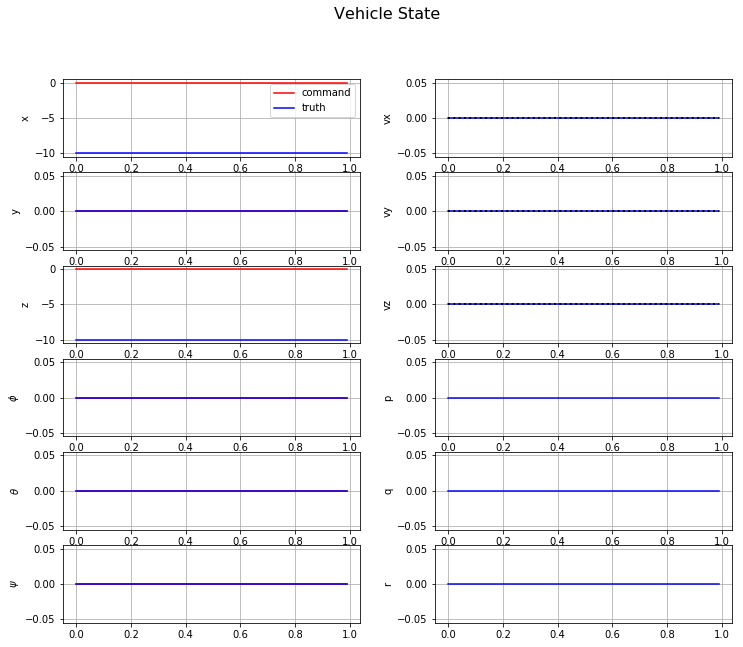

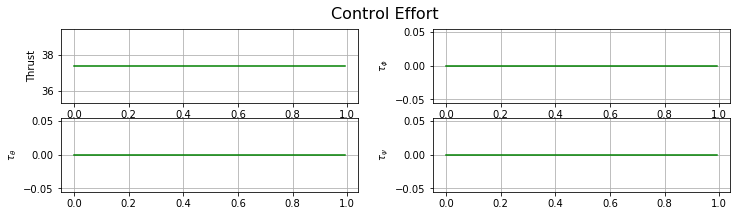

In [7]:
# target dynamics
def target_tick(capture, n, Ts):
    
    # ellipse
    f = 0.05 # Hz
    x = 10*np.sin(2*np.pi*f*n*Ts)
    y = 5*np.cos(2*np.pi*f*n*Ts)
    
    return np.array([[x,y,0]]).T

# Instantiate a quadrotor model with the given initial conditions
quad = Quadrotor(r=np.array([[-10],[0],[-10]]),
                 v=np.array([[0],[0],[0]]),
               Phi=np.array([[0],[0],[0]]))

# Create sensors
camera = Camera(tick=target_tick)
camera.set_transformation(R=Rb2c)

# Register sensors with the sensor manager
sens = SensorManager()
sens.register(camera)

# Instantiate an IBVS controller
ctrl = IBVS(camera.K)

# Instantiate an estimator that gives truth with body velocities
estm = Estimator(body=True)

# Setup a setpoint commander
cmdr = Commander(default=True)

# Run the simulation
sim = Simulator(quad, ctrl, estm, cmdr, sens)
sim.run(1, Ts=0.01)
sim.plot()

## Velocity Observer

In our IBVS controller we will need to use the velocity of the virtual camera frame $\mathcal{F}^{VC}$. Here we design an observer to estimate the velocity of the virtual camera frame.

In [8]:
%%capture
_NO_SIM = True
%run sliding_mode_control.ipynb
_NO_SIM = False

In [9]:
class VelocityObserver(Estimator):
    def __init__(self, camera, body=True):
        super().__init__(body=body)
        self.name = "Virtual Camera Velocity Observer"
        
        self.camera = camera
        
        self.g = 9.81
        self.m = 3.81
        
        # observer variables
        self.v0 = np.zeros((3,1))
        self.vhat = np.zeros((3,1))
        self.q1hat = np.zeros((3,1))
    
    def update(self, quad, u, Ts):
        
        truth = self.get_truth(quad)
        state = np.copy(truth)
        
        x_cam = self.camera.meas
        
        # calculate unit LOS vectors to targets
        hx_veh1 = target_los(x_cam, state)

#         print(x_cam.T, hx_veh1.T)
        
        ########
        ########
        ########
        
        # calculate the depth value when the camera is at the desired pose
        h = -truth[2,0]
        zdes = h/np.cos(np.pi/4)
    
        # LOS vector is the feature q
        q = hx_veh1
        
        # image error
        q1 = q - np.array([[0,0,1]]).T

        # gains
        k1 = 5
        k2 = 0.5
        
        # estimation error equation (19)
        q1err = q1 - self.q1hat
        
        # equation (23)
        Q = state[11, 0] # yaw dot
        f = lambda q1hat: -1/zdes*self.vhat - np.array([[0,-Q,0],[Q,0,0],[0,0,0]]).dot(q1) + k1*q1err
        self.q1hat = rk4(f, self.q1hat, Ts)
        
        # equation (22)
        Rb_2_v1 = rot3(state[6,0],state[7,0],0).T
        force = -Rb_2_v1.dot(np.array([[0,0,u[0]]]).T)/self.m + np.array([[0,0,self.g]]).T
        f = lambda v0: -np.array([[0,-Q,0],[Q,0,0],[0,0,0]]).dot(self.vhat) + force - k2*k1*q1err - 1/zdes*q1err
        self.v0 = rk4(f, self.v0, Ts)
        
        # equation (21)
        self.vhat = self.v0 - k2*q1err
        
        state[3:6] = self.vhat
        
        return state, truth

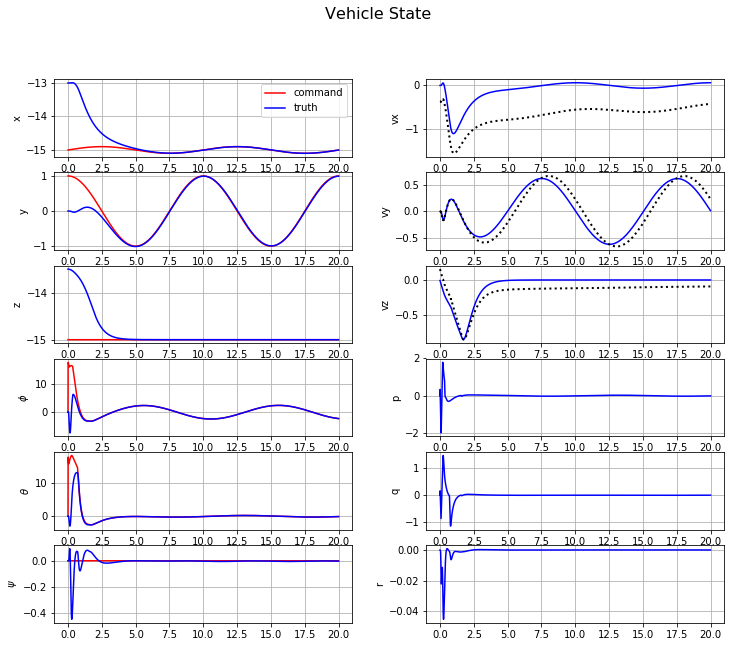

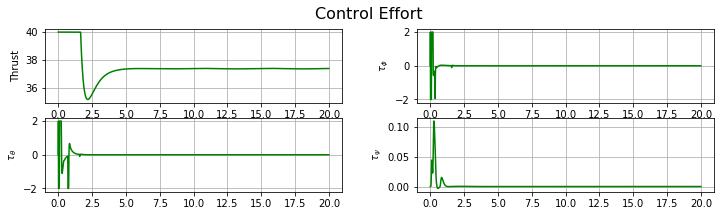

In [15]:
# Instantiate a quadrotor model with the given initial conditions
quad = Quadrotor(r=np.array([[-13],[0],[-13.5]]),
                 v=np.array([[0],[0],[0]]),
               Phi=np.array([[0],[0],[0]]))

def target_tick(capture, n, Ts):
    return np.array([[1,0,0]]).T

# Create sensors
camera = Camera(fps=30, tick=target_tick)
camera.set_transformation(R=Rb2c)

# Register sensors with the sensor manager
sens = SensorManager()
sens.register(camera)

# Instantiate a tracking sliding mode controller
ctrl = SMC()

# Instantiate a virtual camera velocity observer
estm = VelocityObserver(camera, body=False)

# Setup a setpoint commander
cmdr = Commander(default=True)
def set_position(i, Ts):
    f = 0.1
    y = np.cos(2*np.pi*f*i*Ts)
    x = 0.1*np.sin(2*np.pi*f*i*Ts)
    return np.array([-15+x, y, -15])
cmdr.position(set_position)

# Run the simulation
sim = Simulator(quad, ctrl, estm, cmdr, sens)
sim.run(20, Ts=0.01)
sim.plot()

## References

[1] D. Zheng, H. Wang, J. Wang, S. Chen, W. Chen, and X. Liang, “Image-based visual servoing of a quadrotor using virtual camera approach,” IEEE/ASME Trans. Mechatronics, vol. 22, no. 2, pp. 972–982, 2017.